# Threshold Sparse Coding

## Intro

* **Date**: 1/17/2021
* **What**: This is my new attempt at fast sparse coding.  Basically, every neuron whose output is above some threshold fraction of the max neuron output "wins," and keeps it's value.  Otherwise, the output of the neuron is set to zero.  
* **Why**: In so far as each neuron effictively becomes tuned to one particular type of structure, it's problematic to always have the same number of winners in a particular layer.  If out MWTA layer has 5 winners, what happens it there's really only one meaningful structure in the input?  Should it just be split into 5 pieces?  I guess maybe, but still a fixed number of winners feels quite limiting.  In any event, this new architecture should promote sparsity, but also allows a variable number of winners, depending on the strength with which the neurons respond to a particular input.
* **Hopes**: Basically, with this first version, I'll be quite happy if I see basic vanilla sparsity.
* **Limitations**: This section of the intro is quickly becoming a meme.  I almost never know how my networks are probably going to fail when I start an experiment.  This time, I'm guess a silverback flies out of my closet and tears my head from my spine.  Or the digital version of that.

## Code

In [3]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

sl = 28

x_tr = x_tr / 255.0
gp_tr = cp.asarray(x_tr)

In [7]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

## Analysis Dialog

Let the fields be ripe!

<IPython.core.display.Javascript object>


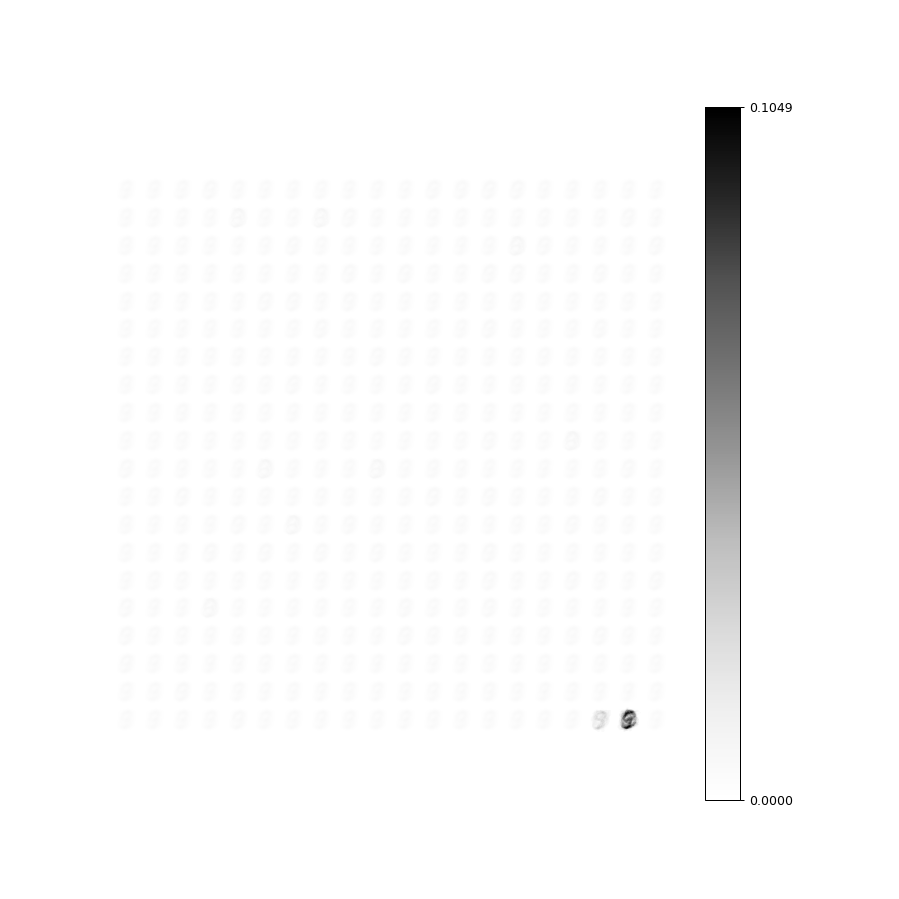

100%|██████████| 10000/10000 [00:04<00:00, 2237.48it/s]


In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000
ex = 2

prec = 1e-10
thresh = 0.9

# Feedforward
w = cp.random.uniform(.15, .16, (N, m_len))
xi = 0.01


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        mxp = cp.maximum(cp.max(p), prec)
        o = cp.where((p / mxp) > thresh, p, 0)
        
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

AAAAAAAAHHHHHHHHHH!!!!!!  Revenge of the fuzzy three!  Well, that was astonishingly hateful.  Let's try again with a higher threshold. 

Also, I'm using noisy initialization rather than constant initialization.

<IPython.core.display.Javascript object>


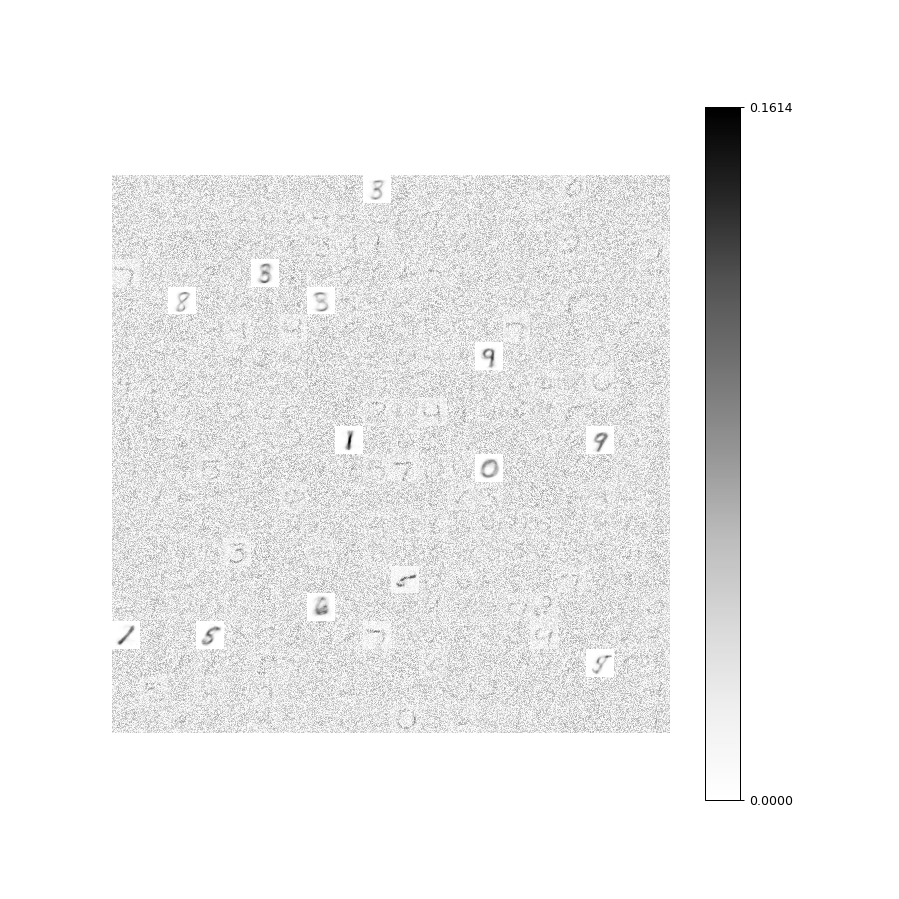

100%|██████████| 10000/10000 [00:04<00:00, 2223.16it/s]


In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000
ex = 2

prec = 1e-10
thresh = 0.95

# Feedforward
w = cp.random.uniform(0, .16, (N, m_len))
xi = 0.01


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        mxp = cp.maximum(cp.max(p), prec)
        o = cp.where((p / mxp) > thresh, p, 0)
        
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Hmm.  Lowering the training constant and raising the max initialization value could do everyone some good.

<IPython.core.display.Javascript object>


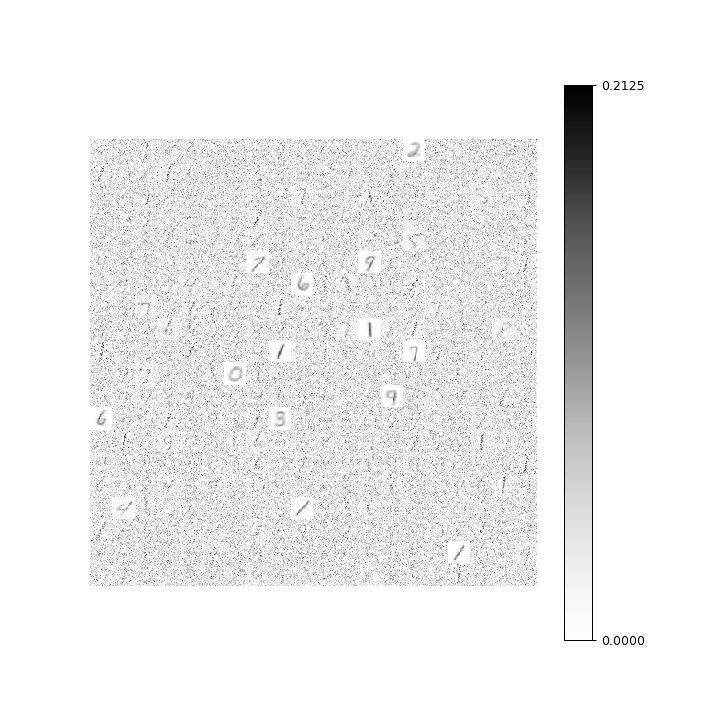

100%|██████████| 10000/10000 [00:04<00:00, 2052.74it/s]


In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.95

# Feedforward
w = cp.random.uniform(0, 1, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        mxp = cp.maximum(cp.max(p), prec)
        o = cp.where((p / mxp) > thresh, p, 0)
        
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Hmmm.

<IPython.core.display.Javascript object>


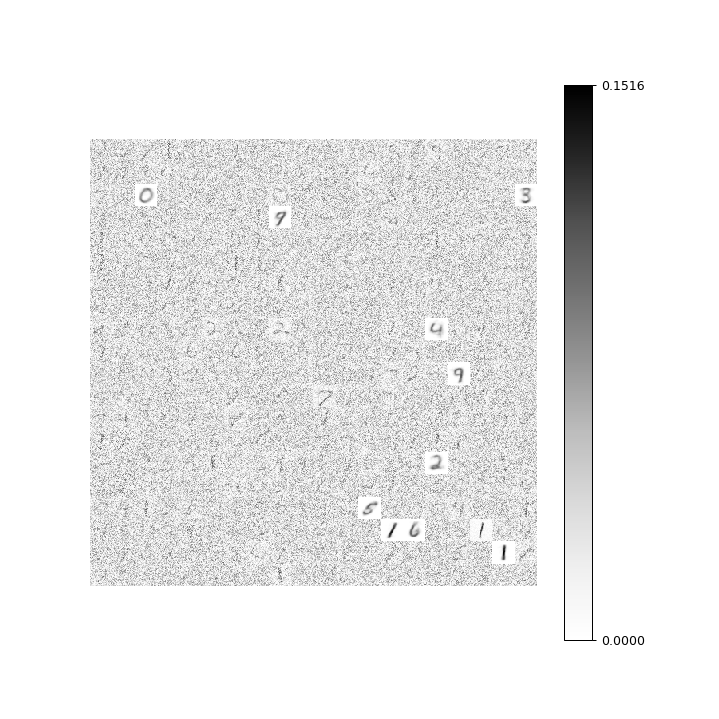

100%|██████████| 10000/10000 [00:04<00:00, 2268.49it/s]


In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.95

# Feedforward
w = cp.random.uniform(0, 0.4, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        mxp = cp.maximum(cp.max(p), prec)
        o = cp.where((p / mxp) > thresh, p, 0)
        
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Up with the `thresh`.

<IPython.core.display.Javascript object>


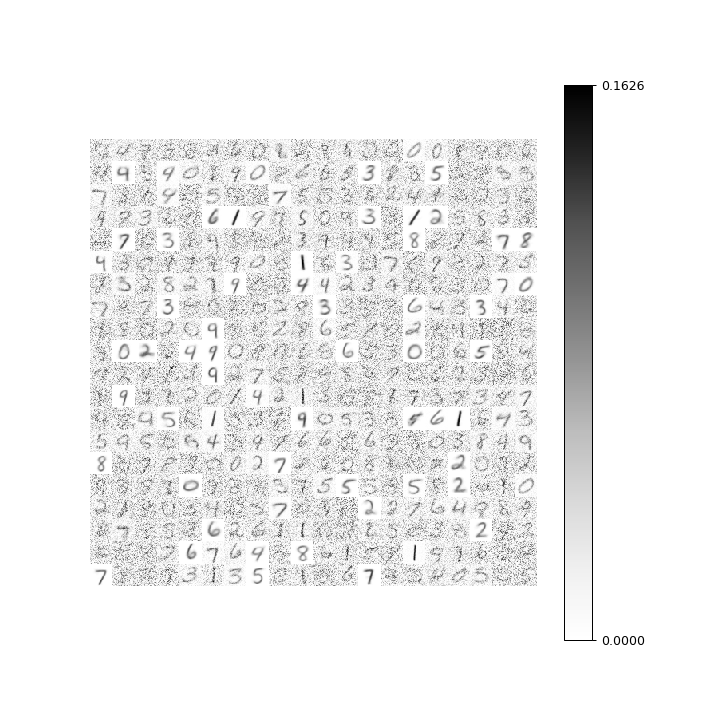

100%|██████████| 10000/10000 [00:04<00:00, 2087.84it/s]


In [13]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 5
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.98

# Feedforward
w = cp.random.uniform(0, 0.4, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        mxp = cp.maximum(cp.max(p), prec)
        o = cp.where((p / mxp) > thresh, p, 0)
        
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Ugh.

<IPython.core.display.Javascript object>


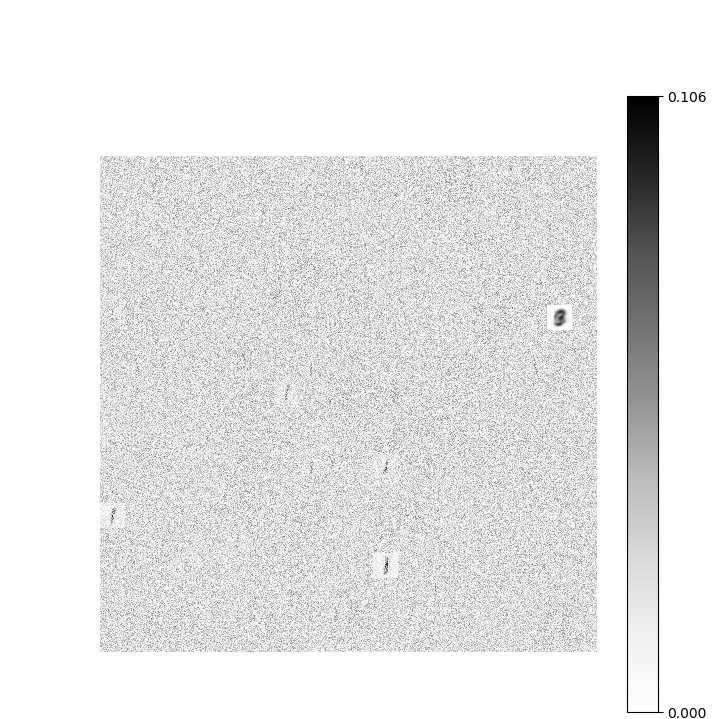

  4%|▍         | 439/10000 [00:00<00:04, 2137.17it/s]


KeyboardInterrupt: 

In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 20
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.9

# Feedforward
w = cp.random.uniform(0, 0.3, (N, m_len))
xi = 0.001


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        mxp = cp.maximum(cp.max(p), prec)
        o = cp.where((p / mxp) > thresh, p, 0)
        
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Oh wait, I think I forgot a crucial step.  I'm supposed to use the weighted average as the "competition value." And by "I'm supposed to," I mean, that's what I thought of on my walk today.

<IPython.core.display.Javascript object>


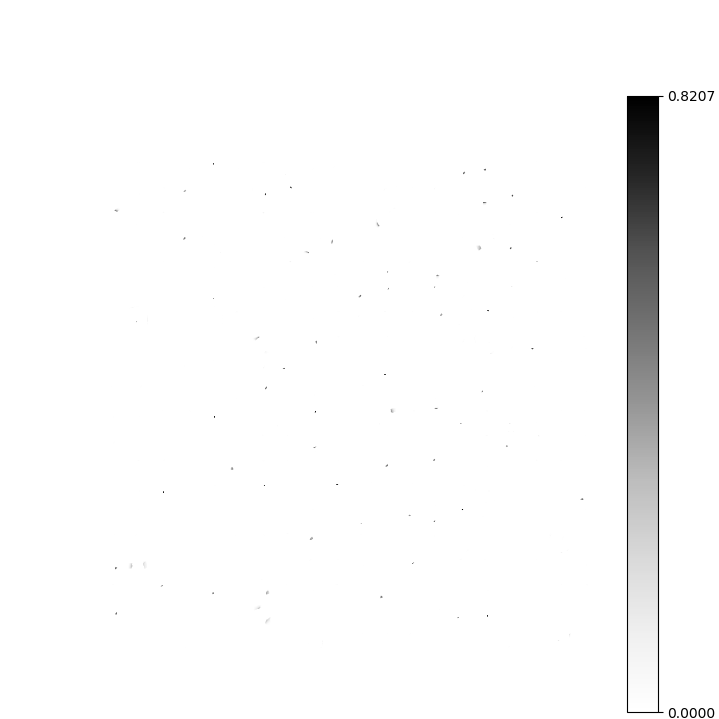

 71%|███████   | 7094/10000 [00:04<00:01, 1712.91it/s]


KeyboardInterrupt: 

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 20
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.9

# Feedforward
w = cp.random.uniform(0, 0.3, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        q = cp.sum(w, axis=1).reshape(-1, 1)
        s = p / q
        mxs = cp.maximum(cp.max(s), prec)
        t = cp.where((s / mxs) > thresh, s, 0)
        o = s * q
        
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Aha!  Lovely, wonderful juice! We're getting sparsity baby!  Now then, my concern is that it tends to the behavior we saw in the CollaborativeAE, in which the neurons try to tile the input as best they can.  Well, let's see.  This should simply be a matter of increasing `thresh`.  Which is of course what I'm going to do.

<IPython.core.display.Javascript object>


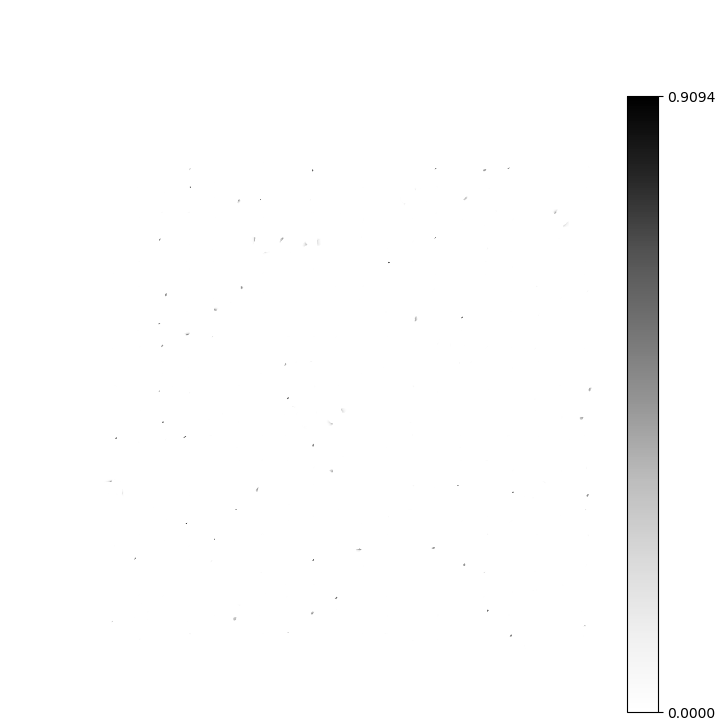

 46%|████▋     | 4648/10000 [00:02<00:02, 1813.57it/s]


KeyboardInterrupt: 

In [16]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 20
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.95

# Feedforward
w = cp.random.uniform(0, 0.3, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        q = cp.sum(w, axis=1).reshape(-1, 1)
        s = p / q
        mxs = cp.maximum(cp.max(s), prec)
        t = cp.where((s / mxs) > thresh, s, 0)
        o = s * q
        
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Hmm.  It may be as I feared.  I'm just going to keep increasing `thresh`until I get what I want.  Then, I'll report.  I promise.

<IPython.core.display.Javascript object>


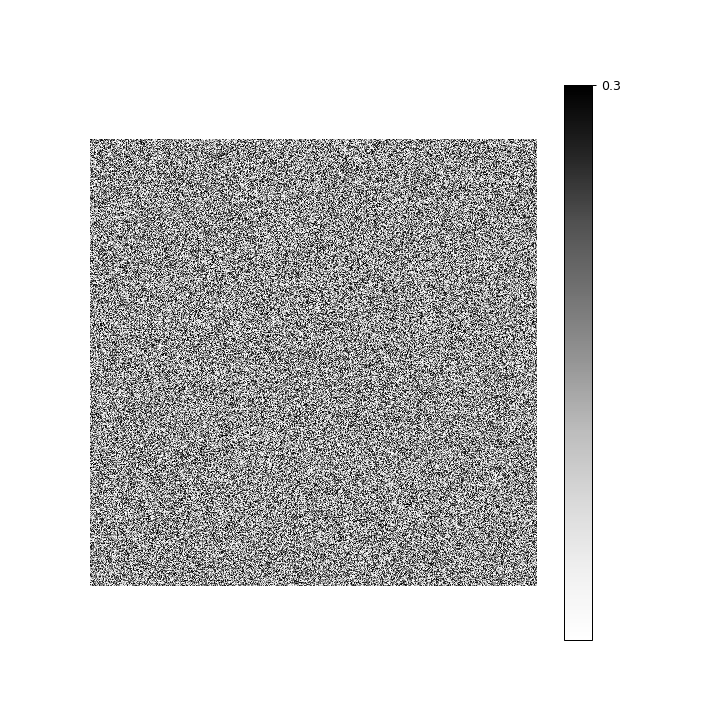

100%|██████████| 1/1 [00:00<00:00, 537.94it/s]


In [21]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 1
T_s = 1

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 1

# Feedforward
w = cp.random.uniform(0, 0.3, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        q = cp.sum(w, axis=1).reshape(-1, 1)
        s = p / q
        mxs = cp.maximum(cp.max(s), prec)
        t = cp.where((s / mxs) > thresh, s, 0)
        o = s * q
                
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Ok, I found it.  I was using `s` to multiply `q` to get `o`, not `t`.  Ok, let's try this again, now that I know what I'm doing.

<IPython.core.display.Javascript object>


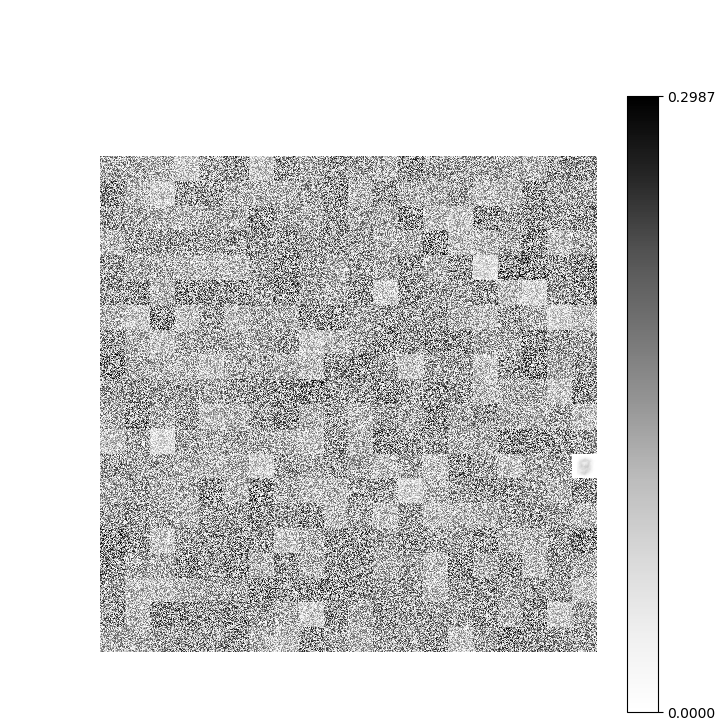

 43%|████▎     | 4306/10000 [00:02<00:03, 1727.56it/s]

KeyboardInterrupt: 

Exception ignored in: 'cupy.core._kernel._can_cast'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in can_cast
KeyboardInterrupt
 43%|████▎     | 4306/10000 [00:02<00:03, 1693.38it/s]


TypeError: output (typecode '?') could not be coerced to provided output parameter (typecode '?') according to the casting rule "unsafe"

In [23]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 20
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.9

# Feedforward
w = cp.random.uniform(0, 0.3, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        q = cp.sum(w, axis=1).reshape(-1, 1)
        s = p / q
        mxs = cp.maximum(cp.max(s), prec)
        t = cp.where((s / mxs) > thresh, s, 0)
        o = t * q
                
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Take a gander at that.  Once it reaches the fuzzy three, it's all over.  Well then, let's see what we can do about that.  (Lower `thresh`)

<IPython.core.display.Javascript object>


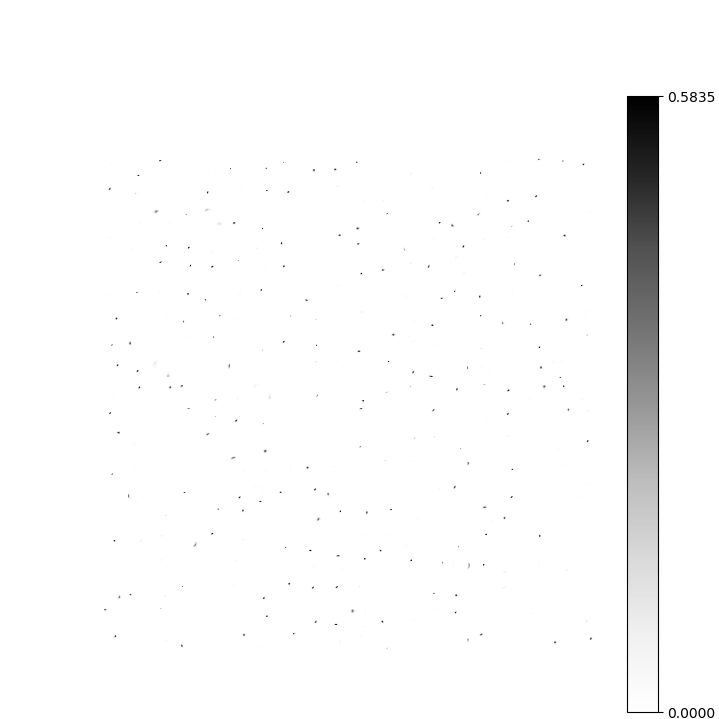

 28%|██▊       | 2796/10000 [00:01<00:04, 1755.65it/s]


KeyboardInterrupt: 

In [24]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 20
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.5

# Feedforward
w = cp.random.uniform(0, 0.3, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        q = cp.sum(w, axis=1).reshape(-1, 1)
        s = p / q
        mxs = cp.maximum(cp.max(s), prec)
        t = cp.where((s / mxs) > thresh, s, 0)
        o = t * q
                
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Hmm.  Ok, not that.  I'll play with this a bit more.

<IPython.core.display.Javascript object>


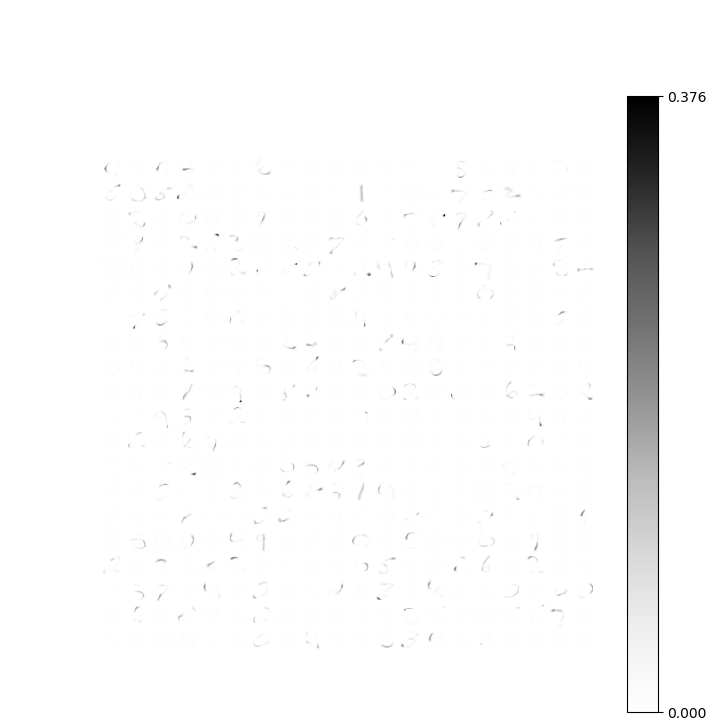

 64%|██████▎   | 6373/10000 [00:03<00:01, 1821.26it/s]


KeyboardInterrupt: 

In [27]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))

Nep = 20
T_s = 10_000

Kx = 20
Ky = 20
N = Kx * Ky
m_len = sl ** 2
tr_len = 60_000

prec = 1e-10
thresh = 0.75

# Feedforward
w = cp.random.uniform(0, 0.3, (N, m_len))
xi = 0.005


for ep in range(Nep):
    inputs = gp_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        q = cp.sum(w, axis=1).reshape(-1, 1)
        s = p / q
        mxs = cp.maximum(cp.max(s), prec)
        t = cp.where((s / mxs) > thresh, s, 0)
        o = t * q
                
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)

        w += w * o * (e / mod_r).T * xi
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Aha!!! Now we're getting somewhere good!  You know what?  I could adjust `thresh` over time to try to achieve a certain average level of sparsity.  Now there's a good idea.  Aight, it's time for dinner, so I'm briefly out.